In [0]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pprint
import torch
import torchvision
import numpy as np
import torch.nn as nn
import time,os
import matplotlib.pyplot as plt

from google.colab import auth, drive,files
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [0]:
grid_number = 7
grid_size = 1/7
box_number = 2
img_size = 448

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

object_class = ['tvmonitor', 'aeroplane', 'sofa', 'motorbike', 'bird', 'sheep', 'train', 'bicycle', 'diningtable', 'cat', 'boat', 'cow', 'chair', 'bottle', 'bus', 'dog', 'horse', 'car', 'pottedplant', 'person']

def target_transform(targets):
    """
    把标记数据转换成 yolo 格式 x,y(以网格长宽为1)w,h(以图片长宽为1)
    """
#     print( targets.get('annotation').get('filename'))
    size =  targets.get('annotation').get('size')
    # xy缩放比例
    scale_x = img_size / int(size.get('width'))
    scale_y = img_size / int(size.get('height'))
#     print('w_h',int(size.get('width')),int(size.get('height')))
    boxs = []
    labels = []
    objects= targets.get('annotation').get('object')
    if type(objects) == dict:
#         print(objects.get('name'),object_class.index(objects.get('name')))
        labels.append(object_class.index(objects.get('name')))
        bound_box = objects.get('bndbox')
        # x,y,w,h,confidence, x,y,w,h 属于 (0,1)相对于整个图片
        box = torch.tensor([
            (int(bound_box.get('xmin')) + int(bound_box.get('xmax')))/ 2 / int(size.get('width')),
            (int(bound_box.get('ymin')) + int(bound_box.get('ymax')))/ 2 / int(size.get('height')),
            (int(bound_box.get('xmax')) - int(bound_box.get('xmin'))) / int(size.get('width')),
            (int(bound_box.get('ymax')) - int(bound_box.get('ymin'))) / int(size.get('height')),
            1,
        ])
#         print('raw',int(bound_box.get('xmin'))*scale_x,int(bound_box.get('ymin'))*scale_y,box)
        boxs.append(box)
    else:
        for x in objects:
            labels.append(object_class.index(x.get('name')))
#             print(x.get('name'),object_class.index(x.get('name')))
            bound_box = x.get('bndbox')
            # x,y,w,h,confidence, x,y,w,h 属于 (0,1)相对于整个图片
            box = torch.tensor([
                (int(bound_box.get('xmin')) + int(bound_box.get('xmax')))/ 2  / int(size.get('width')),
                (int(bound_box.get('ymin')) + int(bound_box.get('ymax')))/ 2  / int(size.get('height')),
                (int(bound_box.get('xmax')) - int(bound_box.get('xmin'))) / int(size.get('width')),
                (int(bound_box.get('ymax')) - int(bound_box.get('ymin'))) / int(size.get('height')),
                1,
            ])
#             print('raw',int(bound_box.get('xmin'))*scale_x,int(bound_box.get('ymin'))*scale_y,box)


            boxs.append(box)
    
    res = torch.zeros((grid_number, grid_number, box_number * 5 + len(object_class)))
#     print(labels)
    # object 分配到网格,x,y 按网格高宽为1 进行缩放
    for box,label in zip(boxs,labels):
        # 根据 cx,cy 判断所属网格
        i,j= (box[:2]/grid_size).floor()
        i,j = int(i), int(j)
        
        # 把 x,y,w,h 归属到相应网格
        box[0] = box[0] * grid_number - i
        box[1] = box[1] * grid_number - j
        box[2] = box[2]
        box[3] = box[3]
        
        bd_boxs = box.repeat(1,box_number)

        index = box_number * 5
        res[i][j][:index] =  bd_boxs
        res[i][j][index + label] = 1
        
        # ---
        boxs = res[:,:,:10].reshape(-1,5)
#     print('encode_data',boxs[boxs[:,4] == 1])
    
    return res

trainset = torchvision.datasets.VOCDetection(root='./data' ,year='2007',
                                             image_set='train'
                                             ,download=True,
                                             transform=transform,
                                             target_transform = target_transform
                                            )

testset = torchvision.datasets.VOCDetection(root='./data' ,year='2007',
                                             image_set='val'
                                             ,download=True,
                                             transform=transform,
                                             target_transform = target_transform
                                            )


0it [00:00, ?it/s]

100%|█████████▉| 459284480/460032000 [00:33<00:00, 13732842.89it/s]

Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar


In [0]:
class YoloV1(nn.Module):
    def __init__(self):
        super(YoloV1, self).__init__()
        C = 20  # number of classes
        print("\n------Initiating YOLO v1------\n")
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=7//2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=3//2),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=128, kernel_size=1, stride=1, padding=1//2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=3//2),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=1//2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=3//2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_layer4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=1//2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=3//2),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=1//2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=3//2),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=1//2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=3//2),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, padding=1//2),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=3//2),
            nn.BatchNorm2d(1024),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_layer5 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, stride=1, padding=1//2),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=3//2),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, stride=1, padding=1//2),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=3//2),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=3//2),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=2, padding=3//2),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
        )
        self.conv_layer6 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=3//2),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=3//2),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1)
        )

        self.conn_layer1 = nn.Sequential(
            nn.Linear(in_features=7*7*1024, out_features=4096),
            nn.LeakyReLU(0.1)
        )
        self.conn_layer2 = nn.Sequential(nn.Linear(in_features=4096, out_features=7 * 7 * (2 * 5 + C)))

    def forward(self, x):
        conv_layer1 = self.conv_layer1(x)
        conv_layer2 = self.conv_layer2(conv_layer1)
        conv_layer3 = self.conv_layer3(conv_layer2)
        conv_layer4 = self.conv_layer4(conv_layer3)
        conv_layer5 = self.conv_layer5(conv_layer4)
        conv_layer6 = self.conv_layer6(conv_layer5)
        flatten = conv_layer5.view(conv_layer5.size(0),-1)
        conn_layer1 = self.conn_layer1(flatten)
        output = self.conn_layer2(conn_layer1)
        return output.reshape(-1,7,7,30)


In [0]:
def test():
    net = YoloV1()
    net.to(device)
    train_loader = DataLoader(trainset, batch_size=32)
    for s,l in train_loader:
        start = time.time()
        sample = s.to(device)
        print(sample.size())
        l = l.to(device)
        res = net(sample)
        print(time.time()-start,res.size(),l.size())
        break

In [0]:
class YoloLoss(nn.Module):
    def __init__(self):
        super(YoloLoss, self).__init__()

    def calculate_iou(self, predict_boxs, target_boxs):
        """
        :param predict_boxs: batch_size 2 * 4
        :param target_boxs: batch_size 2 * 4
        :return: batch_size_2
        """
        predict_cord = torch.zeros_like(predict_boxs).to(device)
        target_cord = torch.zeros_like(target_boxs).to(device)

        predict_cord[:, :, :2] = predict_boxs[:, :, :2] - predict_boxs[:, :, 2:] * grid_size * 0.5
        predict_cord[:, :, 2:] = predict_boxs[:, :, :2] + predict_boxs[:, :, 2:] * grid_size * 0.5

        target_cord[:, :, :2] = target_boxs[:, :, :2] - target_boxs[:, :, 2:] * grid_size * 0.5
        target_cord[:, :, 2:] = target_boxs[:, :, :2] + target_boxs[:, :, 2:] * grid_size * 0.5

        left_top = torch.max(predict_cord[:, :, :2], target_cord[:, :, :2])
        right_bottom = torch.min(predict_cord[:, :, 2:], target_cord[:, :, 2:])

        w_h = right_bottom - left_top
        w_h[w_h < 0] = 0

        i = w_h[:, :, 0] * w_h[:, :, 1]

        predict_area = (predict_cord[:, :, 3] - predict_cord[:, :, 1]) * (predict_cord[:, :, 2] - predict_cord[:, :, 0])
        predict_area[predict_area < 0] = 0
        target_area = (target_cord[:, :, 3] - target_cord[:, :, 1]) * (target_cord[:, :, 2] - target_cord[:, :, 0])

        ious = i / (predict_area + target_area - i)

        return ious



    def forward(self, predict, target):
        """
        predict batch_size x grid_size x grid_size * 30
        target  batch_size x grid_size x grid_size * 30

        """
        #         print(target.size())
        #         predict = predict.reshape(-1,predict.size(3))
        #         target = target.reshape(-1,target.size(3))
        batch_size = target.size(0)
        has_obj_mask = target[:, :, :, 4] == 1

        # 有目标的分类
        predict_classes = predict[has_obj_mask][:, 10:]
        target_classes = target[has_obj_mask][:, 10:]
        # 有目标的分类 loss
        classification_loss = F.mse_loss(predict_classes, target_classes, reduction='sum')

        # 所有bounding boxes
        predict_boxes = predict[:, :, :, :10].reshape(-1, 2, 5)
        target_boxes = target[:, :, :, :10].reshape(-1, 2, 5)
        has_obj_mask = target_boxes[:, 0, 4] > 0.5

        # max iou mask
        responsible_mask = torch.zeros(has_obj_mask.size(0),2).byte().to(device)
        not_responsible_mask = torch.ones(has_obj_mask.size(0),2).byte().to(device)
        ious = torch.zeros(has_obj_mask.size(0),2).to(device)

        # 有目标网格的index ,针对网格内boxes计算iou
        has_obj_index = torch.nonzero(has_obj_mask)

        # --- fast 矩阵计算max iou
        p_boxes = predict_boxes[has_obj_mask][:,:,:4]
        t_boxes = target_boxes[has_obj_mask][:,:,:4]
        ious = self.calculate_iou(p_boxes,t_boxes)
        max_ious, max_index = torch.max(ious,dim=1)
        for i,j in zip(has_obj_index, max_index):
            responsible_mask[i.item(), j.item()] = 1

        # -- slow
        # for i in has_obj_index:
        #     p_boxes = predict_boxes[i[0]][:, :4]
        #     t_boxes = target_boxes[i[0],][:, :4]
        #     iou = self.calculate_iou(p_boxes, t_boxes)
        #     max_iou, responsible_index = iou.max(0)
        #     responsible_mask[i.item(), responsible_index.item()] = 1
        #     ious[i.item(), responsible_index.item()] = max_iou

        not_responsible_mask = not_responsible_mask - responsible_mask

        # 负责预测的bounding box
        target_responsible = target_boxes[responsible_mask]
        predict_responsible = predict_boxes[responsible_mask]
        # ious = ious[responsible_mask]

        # bounding box 不负责预测的
        predict_not_responsible = predict_boxes[not_responsible_mask].reshape(-1, 5)
        # calculate confidence loss where bounding boxes isn't responsible for predicting
        not_predict_confidence_loss = F.mse_loss(predict_not_responsible[:,4],
                                                 torch.zeros(predict_not_responsible.size(0)).to(device),
                                                 reduction='sum')

        # calculate confidence loss
        # predict_confidence_loss = F.mse_loss(predict_responsible[:,4], ious, reduction='sum')
        # print(predict_responsible.size())
        mask = torch.zeros_like(predict_responsible).byte().to(device)
        mask[:,4] = 1
        # print(predict_responsible[mask].size())
        use_iou = False
        # 是否用iou计算confidence loss ,如果不用iou则用1
        if use_iou:
            predict_confidence_loss = F.mse_loss(predict_responsible[mask], max_ious, reduction='sum')
        else:
            predict_confidence_loss = F.mse_loss(predict_responsible[mask], torch.ones(predict_responsible[mask].size()).to(device), reduction='sum')

        # calculate localization error
        predict_boxs_predict_loc = predict_responsible[:, :4]
        target_boxs_predict_loc = target_responsible[:, :4]
        # 若 wh小于0则等于0
        predict_boxs_predict_loc[:, 2:][predict_boxs_predict_loc[:, 2:] < 0] = 0
        xy_loss = F.mse_loss(predict_boxs_predict_loc[:, :2], target_boxs_predict_loc[:, :2], reduction='sum')
        wh_loss = F.mse_loss(torch.sqrt(predict_boxs_predict_loc[:, 2:]), torch.sqrt(target_boxs_predict_loc[:, 2:]),
                             reduction='sum')

        loss = (5 * (xy_loss + wh_loss) + predict_confidence_loss + 0.5 * not_predict_confidence_loss \
               + classification_loss) / batch_size

        loss_dict = {
            'xy_loss': xy_loss.item() / batch_size,
            'wh_loss': wh_loss.item() / batch_size,
            'predict_confidence_loss': predict_confidence_loss.item() / batch_size,
            'not_predict_confidence_loss': not_predict_confidence_loss.item() / batch_size,
            'classification_loss': classification_loss.item() / batch_size,
            'loss': loss.item()
        }
        return loss, loss_dict

def test():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    loss =YoloLoss()
    torch.manual_seed(1)
    train_loader = DataLoader(trainset, batch_size=32,drop_last=True)
    for samples,labels in train_loader:
            labels = labels.to(device)
            break
    predict = labels.clone()
    print(predict[:,:,:,:2].size())
    predict = predict + torch.rand(32,7,7,30).to(device)
    l,d = loss(predict,labels)
    d
# test()

In [0]:
auth.authenticate_user()

def save_to_driver(model,name):

    path = torch.save(model.state_dict(),name)
    
    drive_service = build('drive', 'v3')

    file_metadata = {
      'name': name,
      'mimeType': 'text/plain'
    }
    media = MediaFileUpload(name, 
                            mimetype='text/plain',
                            resumable=True)
    created = drive_service.files().create(body=file_metadata,
                                           media_body=media,
                                           fields='id').execute()
    print('File ID: {}'.format(created.get('id')))

    
def load_model(file_name):
#     drive.mount('/content/drive')
    model = YoloV1()
    path = f'/content/drive/My Drive/{file_name}'
    if os.path.exists(path):
        print('loading model')
        model.load_state_dict(torch.load(path))
        model.eval()
    else:
        print("model isn't exist")
    return model
    


In [0]:
drive.mount('/content/drive')
!ls "/content/drive/My Drive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 alexnet.ipynb	    pytorch_get_start.ipynb   yolo.net
'Colab Notebooks'   resnet.ipynb	      yolo_v1_pytorch.ipynb


In [0]:
torch.autograd.set_detect_anomaly(True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_list = {
    'xy_loss':[],
    'wh_loss':[],
    'predict_confidence_loss':[],
    'not_predict_confidence_loss':[],
    'classification_loss':[],
    'loss':[],
}

def update_lr(optimizer,epoch,r):
    if epoch == 1:
        lr = 10e-4 + r*(10e-3 - 10e-4)
    elif epoch< 70:
        lr = 10e-3
    elif epoch<105:
        lr = 10e-4
    else:
        lr = 10e-5
#     print(lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        

def train(net,epochs,n_epoch=1):
    print(device)
    print(torch.cuda.get_device_name(device))

    criterion = YoloLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=10e-5)#weight_decay = 1.0e-5)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

    train_loader = DataLoader(trainset, batch_size=32,drop_last=True, shuffle=True)

    for epoch in range(n_epoch,epochs+1):
        print(f'epoch : {epoch}  --------------------------------------')
        for i,(samples,labels) in enumerate(train_loader):
            
#             update_lr(optimizer,epoch,r)
            
            optimizer.zero_grad()
            samples = samples.to(device)
            labels = labels.to(device)
            
            predict = net(samples)
            
            loss,loss_dict = criterion(predict,labels)
            for k,v in loss_dict.items():
                loss_list[k].append(v)
            
            loss.backward()
            optimizer.step()
            print(loss.item())
        scheduler.step()

try:
    if 'net' in locals().keys():
        pass
    else:
        net = load_model('yolo.pt')
    net.to(device)
    train(net ,100)
    save_to_driver(net,'yolo.net')
except Exception as e:
    print(e)




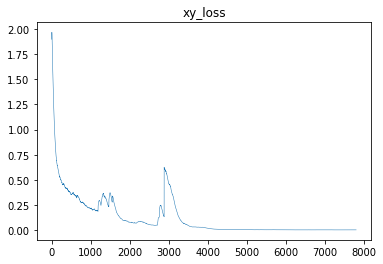

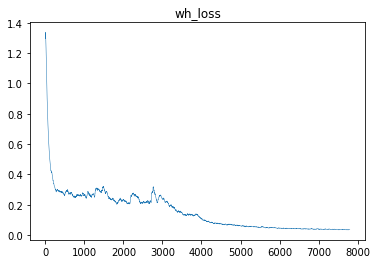

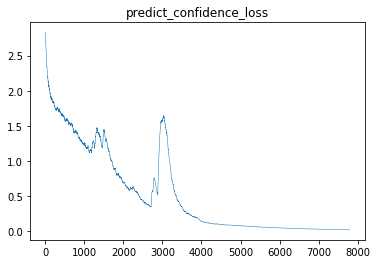

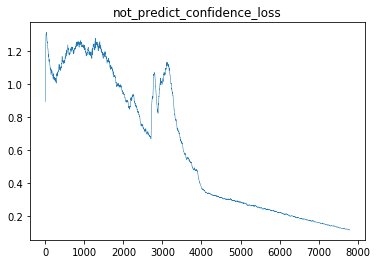

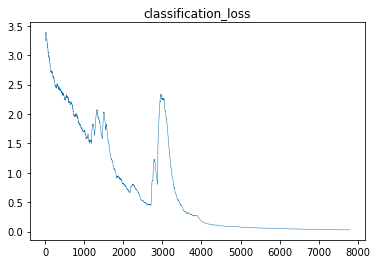

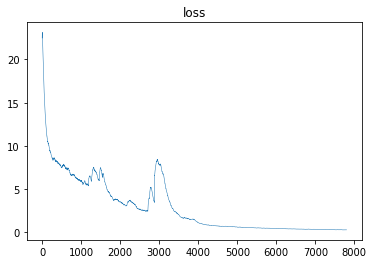

In [0]:
def plot():
    for k,v in loss_list.items():
        plt.title(str(k))
        r = 0.98
        v2 = []
        n = v[0]
        for x in v:
            n = n * r +(1-r)*x
            v2.append(n)
        plt.plot(range(1, len(v2) + 1), v2, linewidth=0.5)
        plt.show()
plot()

In [0]:
def nms(boxes, overlap_threshold=0.5):
    """ 
    :param boxes: (x_min,y_min,weight,height,score)
    :param overlap_threshold: 
    :return: boxes index
    """
    boxes = torch.clamp(boxes, min=0, max=448)
    keep = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2] + boxes[:, 0]
    y2 = boxes[:, 3] + boxes[:, 1]
    scores = boxes[:, 4]

    areas = (x2 - x1) * (y2 - y1)
    _, order = scores.sort(dim=0, descending=True)

    while order.numel() > 0:

        if order.numel() == 1:
            keep.append(order)
            break
        else:
            keep.append(order[0])

        xx1 = torch.max(x1[order[0]], x1[order[1:]])
        yy1 = torch.max(y1[order[0]], y1[order[1:]])
        xx2 = torch.min(x2[order[0]], x2[order[1:]])
        yy2 = torch.min(y2[order[0]], y2[order[1:]])

        w = torch.clamp(xx2 - xx1, min=0)
        h = torch.clamp(yy2 - yy1, min=0)
        inter = w * h

        ovr = inter / (areas[order[0]] + areas[order[1:]] - inter)

        inds = torch.nonzero(ovr <= overlap_threshold).squeeze()
        if not inds.numel():
            break
        order = order[inds + 1]

    return torch.tensor(keep).to(device).long()

In [0]:
def decode_labels(labels):
    """
    yolo labels格式转换成正常,用于plot
    :param labels: [batch_size * 7 * 7 * ((x_center,y_center,width,height,score)*2,classes)]    x,y相对于网格
    :return: class_index : [batch_size * 7 * * 2 * 1].reshape(-1,1) classes 中最大值的index
    :return: boxes : [batch_size * 7 * * 2 * (x_min,y_min,width,height,score)].reshape(-1,5)  x,y相对于图片
    """

    classes = labels[:, :, :, 10:]

    # batch_size * 7 * 7
    class_index = torch.max(classes, dim=3)[1]

    temp = labels[:, :, :, :10].reshape(-1, 7, 7, 2, 5)

    boxes = torch.zeros_like(temp)

    # 长度相对转换
    for xi in range(7):
        for yi in range(7):
            temp[:, xi, yi, :, 0] = (temp[:, xi, yi, :, 0] + xi) / grid_number
            temp[:, xi, yi, :, 1] = (temp[:, xi, yi, :, 1] + yi) / grid_number

    boxes[:, :, :, :, :2] = temp[:, :, :, :, :2] - temp[:, :, :, :, 2:4] / 2
    boxes[:, :, :, :, 2:] = temp[:, :, :, :, 2:]

    class_index = class_index.reshape(-1, 7, 7, 1).expand(-1, 7, 7, 2)

    boxes = boxes.reshape(-1, 5)
    class_index = class_index.reshape(-1, 1)
    return boxes, class_index

In [29]:
test_loader = DataLoader(testset, batch_size=1,)#shuffle=True)
train_loader = DataLoader(trainset, batch_size=1,)#shuffle=True)


def test(model):
    with torch.no_grad():
        for sample,label in test_loader:
#         for sample,label in train_loader:
            sample = sample.to(device)
            label = label.to(device)
            predict = model(sample)
            
            l = YoloLoss()
            loss,loss_dict = l(predict,label)
            print(loss_dict)
            
            labels_box,label_class = decode_labels(label)
            predict_box,predict_class = decode_labels(predict)
            
            threshold = 0.3
            grid_confidence_mask = predict_box[:,4] > threshold
            predict_box = predict_box[grid_confidence_mask]
            predict_class = predict_class[grid_confidence_mask]
            
            # 原始box
            sample = sample.squeeze() * 255
            boxes = labels_box[labels_box[:,4]==1]
            label_class = label_class[labels_box[:,4]==1]
#             print(label_class)
            plot(sample.to('cpu'),boxes.to('cpu'),label_class)
            
            # 预测box
            nms_index = nms(predict_box).long()
            print(f"before nms {predict_box.size()},   nms after : {nms_index.size()}")
            boxes = predict_box[nms_index]
            predict_class = predict_class[nms_index]
            plot(sample.to('cpu'),boxes.to('cpu'),predict_class)
#             return

        
def plot(image,boxes,labels=[]):
    image = image.numpy().astype(np.uint8)
    fig = plt.figure()
    image = np.transpose(image, (1, 2, 0))

    boxes = boxes.numpy() * 448

    plt.imshow(image)
    
    gca = plt.gca()
    for box,label in zip(boxes,labels):

        rect  = plt.Rectangle((box[0], box[1]),box[2],
                      box[3], fill=False,
                      edgecolor='r', linewidth=1)
        gca.add_patch(rect)
        
        gca.text(box[0], box[1]-10,
                        object_class[label],
                        bbox=dict(facecolor='white', alpha=0.9),
                        fontsize=8, color='red')
    plt.show()

try:
    if 'net' in locals().keys():
        print('use net')
    else:
        net = load_model('yolo.net')
        net.to(device)
    test(net)
except Exception as e:
    print(e)

Output hidden; open in https://colab.research.google.com to view.